# Loading and Structuring the chats data

In [1]:
from pathlib import Path
import pandas as pd
import re

In [2]:
def get_structured_chats(chats:list):
    
    chats = ''.join(chats)
    chats = chats.replace("\n\n"," ")
    chats = chats.split('\n')

    pattern_str = r'([0-9]+(/[0-9]+)+)'

    structured_chats = []
    previous_chat = ""
    right_match = True
    hold_chat = False
    count = 0

    # Iterating through every chat message
    for chat_number,chat in enumerate(chats):
        #removes unwanted blank spaces
        chat = re.sub(' +', ' ', chat)
        chat = chat.strip()
        
        # To make split into atleast 2 halfs to handle chat messages without date
        modified_chat = chat + "x:x-x,x"
        date,rest_text = modified_chat.split(",")[:2]
        date = date.strip()

        # To check whether next chat is of valid format containing date
        if chat_number+1 < len(chats): 
            next_modified_chat = chats[chat_number+1] + "x:x-x,x"
            next_date,next_rest_text = next_modified_chat.split(",")[:2]
            next_date = next_date.strip()

            # Hold the current chat message for appending into structured_chats if next chat message is not valid
            if re.match(pattern_str, next_date):
                hold_chat = False
            else:
                hold_chat = True     
        
        # To check whether current message is valid or not
        if not re.match(pattern_str, date) and right_match!=False:
            
            # If not valid store the previous chat message 
            previous_chat = chats[chat_number-1]
            right_match = False
            
        
        # Keep on adding invalid messages to previous message (which is correct)
        if not re.match(pattern_str, date):
            previous_chat = previous_chat + " " +  chat
            
        elif not hold_chat and right_match == False:
            # if no invalid chat message left, then append the previous message (correct) to new_chat
            structured_chats.append(previous_chat)
            previous_chat = ""

        
        # if current chat and next chat is valid
        if not hold_chat and re.match(pattern_str, date):
            right_match = True
            structured_chats.append(chat)

        # if chat number is last and chat messages are not valid
        if (chat_number+1) == len(chats) and right_match==False:
            structured_chats.append(previous_chat)
            

    return structured_chats

In [3]:
def get_notifications_splitted(chats:list):

    notifications = []
    without_notifications = []

    for chat in chats:

        chat_backup = chat

        chat = chat.split(',')[1:]
        chat =  "".join(chat) 
        chat = chat.split('-')[1:]   
        chat = ''.join(chat) 
        
        if ":" not in chat:
            notifications.append(chat_backup)
        else:
            without_notifications.append(chat_backup)
                                                
    return notifications,without_notifications

In [4]:
def get_tablular_chats(chats,table_type:str):

    dates = []
    timestamps = []
    username = []
    message = []
    tabular_chat = None
        
    for chat in chats:
        
        chat_splitted = chat.split(",")
        date,rest_text = chat_splitted[0],chat_splitted[1:]
        rest_text = ','.join(rest_text)
        rest_text = rest_text.strip()
        date = date.strip()
       
        chat_splitted = rest_text.split("-")
        time,rest_text = chat_splitted[0],chat_splitted[1:]
        rest_text = '-'.join(rest_text)
        rest_text = rest_text.strip()
        time = time.strip()


        if table_type == 'without_notifications':

            chat_splitted = rest_text.split(":")
            person,rest_text = chat_splitted[0],chat_splitted[1:]
            rest_text = ':'.join(rest_text)
            rest_text = rest_text.strip()
            person = person.strip()

            dates.append(date)
            timestamps.append(time)
            username.append(person)
            message.append(rest_text)

        elif table_type == 'only_notifications':

            dates.append(date)
            timestamps.append(time)
            message.append(rest_text)

        else:
            print("specify correct table type (without_notifications/only_notifications)")
            return None
    

    if table_type == 'without_notifications':

        tabular_chat = pd.DataFrame({"Date":dates,"time":timestamps,"username":username,"message":message})

    elif table_type == 'only_notifications':
        
        tabular_chat = pd.DataFrame({"Date":dates,"time":timestamps,"notifictions":message})
        
             

    return tabular_chat  
       

In [5]:
def load_chats_table(chatFile:Path):

    with open(chatFile,encoding='utf-8') as textFile:
        chats = textFile.readlines()

        structured_chats = get_structured_chats(chats)
        only_notificatitons,without_notifications = get_notifications_splitted(structured_chats)
        only_notifications_table = get_tablular_chats(only_notificatitons,table_type = 'only_notifications')
        without_notifications_table = get_tablular_chats(without_notifications,table_type = 'without_notifications')

    return only_notifications_table,without_notifications_table

In [6]:
CHAT_FILE = Path('Chats/WhatsApp Chat with 20BCS-38 7th Semester.txt') 

In [7]:
 only_notifications,without_notifications = load_chats_table(CHAT_FILE)

In [8]:
only_notifications.head()

,Date,time,notifictions
0,29/07/23,12:19 pm,Messages and calls are end-to-end encrypted. N...
1,23/07/23,2:06 pm,"Sourabh 7 Mentor created group ""Final year CSE..."
2,29/07/23,12:19 pm,Sourabh 7 Mentor added you
3,29/07/23,12:19 pm,Sourabh 7 Mentor added +91 79799 69265
4,29/07/23,12:35 pm,Sourabh 7 Mentor added +91 98722 29498


In [9]:
without_notifications.head()

,Date,time,username,message
0,29/07/23,12:39 pm,+91 70045 64005,Already Responded Registration Done
1,29/07/23,1:11 pm,+91 83077 89067,Garima 20BCS2031 Registration done! 20BCS9624...
2,29/07/23,3:12 pm,Sourabh 7 Mentor,gaurav 20bcs1316 mohan 20bcs2968 vasu 20bcs793...
3,30/07/23,7:42 pm,+91 6376 881 983,20bcs7936 Vasu Solanki Done
4,31/07/23,9:50 am,"Karan CR Sem5,6",*Most Urgent:* *Accenture Registration :* Stud...


# Feature engineering Date and time columns

In [10]:
def get_24_hrs_format(date:str,time:str):

    meridiem_regx = r'[A-Za-z][A-Za-z]'
    meridiem_match = re.search(meridiem_regx,time)
    meridiem = meridiem_match.group() # extraxt am/pm

    time = time.replace(meridiem,"") # extract hh:mm
    hour,minutes = time.split(':')

    hour = int(hour)
    minutes = int(minutes)

    # converting to 24 hours format

    if hour==12 and meridiem=='am': hour = 0

    if hour>12 and meridiem == 'pm': hour+=12
    
    if hour<10: hour = f"0{hour}"

    if minutes<10:minutes = f"0{minutes}"        


    datetime = f"{date} {hour}:{minutes}"
    
    return datetime

In [11]:
def get_24_hours_datetimes(dates,times) :

    date_times = []

    for date,time in zip(dates,times):

        date_time = get_24_hrs_format(date,time)
        date_times.append(date_time)


    return date_times
    

In [12]:
dates = without_notifications.Date.values
times = without_notifications.time.values

datetime24 = get_24_hours_datetimes(dates,times)
without_notifications.insert(2,"datetime24",datetime24)
without_notifications.datetime24 = pd.to_datetime(without_notifications.datetime24,format='%d/%m/%y %H:%M')
without_notifications.insert(2,"only_date",without_notifications.datetime24.dt.date)

without_notifications = without_notifications.assign(

    hour = without_notifications.datetime24.dt.hour,
    minutes = without_notifications.datetime24.dt.minute,

    Day = without_notifications.datetime24.dt.day,
    Month = without_notifications.datetime24.dt.month,
    Month_name = without_notifications.datetime24.dt.month_name(),
    Year = without_notifications.datetime24.dt.year,

    weekday = without_notifications.datetime24.dt.dayofweek,
    weekday_name = without_notifications.datetime24.dt.day_name(),

)


In [13]:
without_notifications.head()

,Date,time,only_date,datetime24,username,message,hour,minutes,Day,Month,Month_name,Year,weekday,weekday_name
0,29/07/23,12:39 pm,2023-07-29,2023-07-29 12:39:00,+91 70045 64005,Already Responded Registration Done,12,39,29,7,July,2023,5,Saturday
1,29/07/23,1:11 pm,2023-07-29,2023-07-29 01:11:00,+91 83077 89067,Garima 20BCS2031 Registration done! 20BCS9624...,1,11,29,7,July,2023,5,Saturday
2,29/07/23,3:12 pm,2023-07-29,2023-07-29 03:12:00,Sourabh 7 Mentor,gaurav 20bcs1316 mohan 20bcs2968 vasu 20bcs793...,3,12,29,7,July,2023,5,Saturday
3,30/07/23,7:42 pm,2023-07-30,2023-07-30 07:42:00,+91 6376 881 983,20bcs7936 Vasu Solanki Done,7,42,30,7,July,2023,6,Sunday
4,31/07/23,9:50 am,2023-07-31,2023-07-31 09:50:00,"Karan CR Sem5,6",*Most Urgent:* *Accenture Registration :* Stud...,9,50,31,7,July,2023,0,Monday


# Most Active Participants

In [180]:
from datetime import datetime,timedelta,date
from dateutil.relativedelta import relativedelta
import calendar
import numpy as np

In [224]:
def all_years_wise_activity(active_username,chat_details,start_year,end_year):
    
    start_date = datetime(start_year,1,1)
    end_date = datetime(end_year,1,1)

    delta = relativedelta(years=1)

    years = []

    while start_date <= end_date:
        years.append(start_date.year)
        start_date += delta

    user_activity = [0 for count in range(len(years))] 
    username = [active_username for count in range(len(years))] 

    active_user_details = chat_details[chat_details.username == active_username]
    activity_period = active_user_details[(active_user_details.Year >= start_year) & (active_user_details.Year <= end_year)]

    activity_details = activity_period.Year.value_counts()

    year_data = activity_details.index
    activity_data = activity_details.values

    for year,activity in zip(year_data,activity_data):
        index = years.index(year)
        user_activity[index] = activity

    
    return username,years,user_activity

In [231]:
def all_months_wise_activity(active_username,chat_details,year,start_month,end_month):
    

    start_date = datetime(year,start_month,1)
    end_date = datetime(year,end_month,1)

    delta = relativedelta(months=1)

    months = []
    
    while start_date <= end_date:
        months.append(start_date.month)
        start_date += delta

    user_activity = [0 for count in range(len(months))] 
    username = [active_username for count in range(len(months))]

    active_user_details = chat_details[chat_details.username == active_username]
    activity_period = active_user_details[(active_user_details.Month >= start_month) & (active_user_details.Month <= end_month)]
    
    activity_details = activity_period.Month.value_counts()

    month_data = activity_details.index
    activity_data = activity_details.values

    for month,activity in zip(month_data,activity_data):

        index = months.index(month)
        user_activity[index] = activity

    #provide month number
    month_names = []

    for month_number in months:
        datetime_object = datetime.strptime(str(month_number), "%m")
        full_month_name = datetime_object.strftime("%B")
        month_names.append(full_month_name)


    return username,month_names,user_activity


In [233]:
def all_days_wise_activity(active_username,chat_details,start_year,start_month,start_day,end_year,end_month,end_day):

    start_date = date(start_year,start_month,start_day)
    end_date = date(end_year,end_month,end_day)

    delta = relativedelta(days=1)

    dates = []

    while start_date <= end_date:
        dates.append(start_date)
        start_date += delta

    user_activity = [0 for count in range(len(dates))] 
    username = [active_username for count in range(len(dates))]


    active_user_details = chat_details[chat_details.username == active_username]
    activity_period = active_user_details[(active_user_details.only_date >= start_date) & (active_user_details.only_date <= end_date)]

    activity_details =  activity_period.only_date.value_counts()

    dates_data = activity_details.index
    activity_data = activity_details.values

    for date_data,activity in zip(dates_data,activity_data):

        index = dates.index(date_data)
        user_activity[index] = activity
        
         
    return username,dates,user_activity      



In [227]:
def all_hours_wise_activity(active_username,chat_details,year,month,start_day,end_day,start_hour,end_hour):
    
    start_dateHours = datetime(year,month,start_day,start_hour,0,0)
    end_dateHours = datetime(year, month,end_day,end_hour,0,0)

    delta = timedelta(hours=1)

    string_dateHours = []

    while start_dateHours <= end_dateHours:

        string_dateHour = ':'.join(str(np.datetime64(start_dateHours)).split(':')[:-1])
        string_dateHours.append(string_dateHour)
        start_dateHours += delta

    user_activity = [0 for count in range(len(string_dateHours))] 
    username = [active_username for count in range(len(string_dateHours))] 

    active_user_details = chat_details[chat_details.username == active_username]
    activity_period = active_user_details[(active_user_details.datetime24>=start_dateHours)&(active_user_details.datetime24<=end_dateHours)]
    
    dateHours_data = activity_period.datetime24.values

    for dateHour in dateHours_data:
        dateHour = ':'.join(str(dateHour).split(':')[:-2])

        if dateHour in string_dateHours:
            index = string_dateHours.index(dateHour)
            user_activity[index]+=1   

    numpy_dateHours = []

    for dateHour in string_dateHours:
        numpy_dateHour = np.datetime64(dateHour)
        numpy_dateHours.append(numpy_dateHour)
        

    return username,numpy_dateHours,user_activity

In [235]:
def all_minutes_wise_activity(active_username,chat_details,year,month,day,start_hour,start_minutes,end_hour,end_minutes):
    
    start_dateHoursMinutes = datetime(year,month,day,start_hour,start_minutes,0)
    end_dateHoursMinutes = datetime(year, month,day,end_hour,end_minutes,0)

    delta = timedelta(minutes=1)

    string_dateHoursMinutes = []

    while start_dateHoursMinutes <= end_dateHoursMinutes:

        string_dateHourMinutes = ':'.join(str(np.datetime64(start_dateHoursMinutes)).split(':')[:-1])
        string_dateHoursMinutes.append(string_dateHourMinutes)
        start_dateHoursMinutes += delta

    user_activity = [0 for count in range(len(string_dateHoursMinutes))] 
    username = [active_username for count in range(len(string_dateHoursMinutes))] 

    active_user_details = chat_details[chat_details.username == active_username]
    activity_period = active_user_details[(active_user_details.datetime24>=start_date)&(active_user_details.datetime24<=end_date)]
    
    dateHoursMinutes_data = activity_period.datetime24.values
    
    for dateHourMinute in dateHoursMinutes_data:
        dateHourMinute = ':'.join(str(dateHourMinute).split(':')[:-1])

        if dateHourMinute in string_dateHoursMinutes:
            index = dateHoursMinutes.index(dateHourMinute)
            user_activity[index]+=1   

    numpy_dateHoursMinutes = []

    for dateHourMinute in string_dateHoursMinutes:
        numpy_dateHourMinute = np.datetime64(dateHourMinute)
        numpy_dateHoursMinutes.append(numpy_dateHourMinute)
        

    return username,numpy_dateHoursMinutes,user_activity


In [293]:
def all_weekday_wise_activity(username,chat_details,year,month):
    _,_,w1_user_activity = all_days_wise_activity(username,chat_details,year,month,1,year,month,7)
    _,_,w2_user_activity = all_days_wise_activity(username,chat_details,year,month,8,year,month,14)
    _,_,w3_user_activity = all_days_wise_activity(username,chat_details,year,month,15,year,month,21)
    username,weekdates,w4_user_activity = all_days_wise_activity(username,chat_details,year,month,22,year,month,28)

    weekdays_names = []

    for date in weekdates:
        day_name = calendar.day_name[date.weekday()]
        weekdays_names.append(day_name)


    return  username,weekdays_names,\
            [w1_user_activity,w2_user_activity,w3_user_activity,w4_user_activity]    


In [284]:
top_active_users = 7
active_participation_count = without_notifications.username.value_counts()[:top_active_users]
active_users = active_participation_count.index

In [294]:
timeline_plot_names = ["Years","Months","Weekdays","Days","Hours","Minutes"]

users_timeline_plotting_details = {}

for user in active_users:

    users_timeline_plotting_details[user] = {}

    for timeline_name in timeline_plot_names:

        if timeline_name == "Weekdays":
            users_timeline_plotting_details[user].update({timeline_name:{
                                            "username":"","x":"",
                                            "y1":"","y2":"","y3":"","y4":""}})

            continue

        users_timeline_plotting_details[user].update({timeline_name:{"username":"","x":"","y":""}})


In [295]:
chat_details = without_notifications.copy()

for username in active_users:

    year_wise_username,years,per_year_user_activity = all_years_wise_activity(username,chat_details,start_year = 2023,end_year=2023)
    month_wise_username,months,per_month_user_activity = all_months_wise_activity(username,chat_details,year=2023,start_month=7,end_month=11)
    weekday_wise_username,weeks,per_week_user_activity = all_weekday_wise_activity(username,chat_details,year=2023,month=10)
    day_wise_username,days,per_day_user_activity = all_days_wise_activity(username,chat_details,start_year=2023,start_month=8,start_day=1,end_year =2023,end_month=8,end_day=30)
    hour_wise_username,hours,per_hour_user_activity = all_hours_wise_activity(username,chat_details,year=2023,month=8,start_day=3,end_day=3,start_hour=10,end_hour=20)
    minute_wise_username,minutes,per_minute_user_activity = all_minutes_wise_activity(username,chat_details,year=2023,month=8,day=3,start_hour = 15,end_hour=15,start_minutes=10,end_minutes=50)
    
   
    users_timeline_plotting_details[username]["Years"]["username"] = year_wise_username
    users_timeline_plotting_details[username]["Years"]["x"] = years
    users_timeline_plotting_details[username]["Years"]["y"] = per_year_user_activity

    users_timeline_plotting_details[username]["Months"]["username"] = month_wise_username
    users_timeline_plotting_details[username]["Months"]["x"] = months
    users_timeline_plotting_details[username]["Months"]["y"] = per_month_user_activity

    users_timeline_plotting_details[username]["Days"]["username"] = day_wise_username
    users_timeline_plotting_details[username]["Days"]["x"] = days
    users_timeline_plotting_details[username]["Days"]["y"] = per_day_user_activity

    users_timeline_plotting_details[username]["Weekdays"]["username"] = weekday_wise_username
    users_timeline_plotting_details[username]["Weekdays"]["x"] = weeks
    users_timeline_plotting_details[username]["Weekdays"]["y1"] = per_week_user_activity[0]
    users_timeline_plotting_details[username]["Weekdays"]["y2"] = per_week_user_activity[1]
    users_timeline_plotting_details[username]["Weekdays"]["y3"] = per_week_user_activity[2]
    users_timeline_plotting_details[username]["Weekdays"]["y4"] = per_week_user_activity[3]

    users_timeline_plotting_details[username]["Hours"]["username"] = hour_wise_username
    users_timeline_plotting_details[username]["Hours"]["x"] = hours
    users_timeline_plotting_details[username]["Hours"]["y"] = per_hour_user_activity

    users_timeline_plotting_details[username]["Minutes"]["username"] = minute_wise_username
    users_timeline_plotting_details[username]["Minutes"]["x"] = minutes
    users_timeline_plotting_details[username]["Minutes"]["y"] = per_minute_user_activity
    

In [296]:
timeline_plot_names = ["Years","Months","Weekdays","Days","Hours","Minutes"]

timeline_type_dataframe = {timeline : "" for timeline in timeline_plot_names }

for timeline in timeline_plot_names:

    df_timeline_list = []

    for user in active_users:
        df = pd.DataFrame(users_timeline_plotting_details[user][timeline])
        df_timeline_list.append(df)

    timeline_df = pd.concat(df_timeline_list,ignore_index=True)
    timeline_type_dataframe[timeline] =  timeline_df   


In [232]:
import plotly.express as px

figures = []

for timeline_type in timeline_type_dataframe.keys():

    timeline_df = timeline_type_dataframe[timeline_type]

    if timeline_type == "Weekdays":

        fig = px.bar(timeline_df, x="x", y="y", 
                    labels={
                            "x": timeline_type,
                            "y": "Message count",
                            "username": "Users"
                        },

                    title=f"{timeline_type} timeline", 
                    color='username'
                    
                    )

        figures.append(fig)  
        continue          



    fig = px.line(timeline_df, x="x", y="y", 
                labels={
                        "x": timeline_type,
                        "y": "Message count",
                        "username": "Users"
                    },

                title=f"{timeline_type} timeline", 
                color='username',markers = True
                
                )

    figures.append(fig)
    # fig.show()



In [235]:
# I largely keep the codes and comments the same as the original answer, with the modification highlighted under '#######'
import plotly.express as px
import plotly.subplots as sp

# Create figures in Express

traces = []

for idx,figure in enumerate(figures):

    figure_trace = []

    for trace in range(len(figure["data"])):

        # if idx==0:
        #     figure["data"][trace]['showlegend'] = False

        figure_trace.append(figure["data"][trace])
        # figure["data"][trace]['showlegend'] = False 

    traces.append(figure_trace)    



   
# Create a 1x2 subplot
this_figure = sp.make_subplots(rows = 1, cols = len(traces), subplot_titles = ['', 'Line'])
this_figure.update_layout(height = 500, width = 2500, title_text = "User timelines", title_font_size = 25)

# Get the Express fig broken down as traces and add the traces to the proper plot within the subplot

for idx,figure_traces in enumerate(traces):

    for trace in figure_traces:
        this_figure.append_trace(trace, row = 1, col = idx+1)


    
this_figure.show()

# Converting raw data into Data frame

In [ ]:
data = {
    'date':message_date,
    'time':message_time,
    'username':username,
    'chats':chats,    
}

In [ ]:
WCA=pd.DataFrame(data)
WCA_copy = WCA.copy()
WCA

,date,time,username,chats
0,8/2/22,6:44 PM,+91 6395 347 424,<Media omitted>
1,8/2/22,6:44 PM,+91 6395 347 424,<Media omitted>
2,8/2/22,6:44 PM,+91 6395 347 424,<Media omitted>
3,8/2/22,6:44 PM,+91 6395 347 424,<Media omitted>
4,8/2/22,6:44 PM,+91 6395 347 424,<Media omitted>
...,...,...,...,...
1533,9/18/22,1:31 AM,Rahul Sem 6,https://youtu.be/eo5bmse-Chs
1534,9/18/22,1:42 AM,Rahul Sem 6,https://youtu.be/fqfUwFmEbJU
1535,9/18/22,2:03 AM,+91 79090 27850,"69 signatures are still needed, can you add yo..."
1536,9/18/22,7:45 AM,+91 97791 17726,https://twitter.com/MirrorNow/status/157131591...


In [ ]:
WCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1538 non-null   object
 1   time      1538 non-null   object
 2   username  1538 non-null   object
 3   chats     1538 non-null   object
dtypes: object(4)
memory usage: 48.2+ KB


In [ ]:
# pd.set_option("max_colwidth", None)
WCA.tail()

,date,time,username,chats
1533,9/18/22,1:31 AM,Rahul Sem 6,https://youtu.be/eo5bmse-Chs
1534,9/18/22,1:42 AM,Rahul Sem 6,https://youtu.be/fqfUwFmEbJU
1535,9/18/22,2:03 AM,+91 79090 27850,"69 signatures are still needed, can you add yo..."
1536,9/18/22,7:45 AM,+91 97791 17726,https://twitter.com/MirrorNow/status/157131591...
1537,9/18/22,7:59 AM,+91 97791 17726,https://www.google.com/amp/s/m.jagran.com/lite...


In [ ]:
import itertools
count=0

check_12_24= WCA["time"][0].split(':')

if 'AM' in check_12_24[1] or 'PM' in check_12_24[1]: #checking for 24 hours time
        
    for t in WCA["time"]:

        time=""

        time_split= t.split(":")

        time_split_hrs= time_split[0]
        time_split_mins=time_split[1].split(" ")[0]

        meridiem = t.split(":")[1]
        meridiem = meridiem.split(" ")[1]

        if(meridiem=='PM' and int(time_split_hrs)<12):
            time = str(int(t.split(":")[0])+12)
            time = time+":"+time_split_mins
        elif int(time_split_hrs)==12:
            time = str(int(t.split(":")[0])+12)
            time = "00:"+time_split_mins
        else:
            time = str(int(t.split(":")[0]))
            time = time+":"+time_split_mins


        WCA["time"][count]=time
        count+=1

In [ ]:
WCA.head()

,date,time,username,chats
0,8/2/22,18:44,+91 6395 347 424,<Media omitted>
1,8/2/22,18:44,+91 6395 347 424,<Media omitted>
2,8/2/22,18:44,+91 6395 347 424,<Media omitted>
3,8/2/22,18:44,+91 6395 347 424,<Media omitted>
4,8/2/22,18:44,+91 6395 347 424,<Media omitted>


In [ ]:
WCA["date_time"]=WCA["date"]+" "+WCA["time"]
WCA["date_time"]=pd.to_datetime(WCA["date_time"])
WCA.head()

,date,time,username,chats,date_time
0,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00
1,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00
2,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00
3,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00
4,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00


In [ ]:
WCA["Year"]=WCA["date_time"].dt.year
WCA["Month_name"]=WCA["date_time"].dt.month_name()
WCA["Month"]=WCA["date_time"].dt.month
WCA["Day"]=WCA["date_time"].dt.day
WCA["Hours"]=WCA["date_time"].dt.hour
WCA["Minutes"]=WCA["date_time"].dt.minute

In [ ]:
WCA.tail()

,date,time,username,chats,date_time,Year,Month_name,Month,Day,Hours,Minutes
1533,9/18/22,1:31,Rahul Sem 6,https://youtu.be/eo5bmse-Chs,2022-09-18 01:31:00,2022,September,9,18,1,31
1534,9/18/22,1:42,Rahul Sem 6,https://youtu.be/fqfUwFmEbJU,2022-09-18 01:42:00,2022,September,9,18,1,42
1535,9/18/22,2:03,+91 79090 27850,"69 signatures are still needed, can you add yo...",2022-09-18 02:03:00,2022,September,9,18,2,3
1536,9/18/22,7:45,+91 97791 17726,https://twitter.com/MirrorNow/status/157131591...,2022-09-18 07:45:00,2022,September,9,18,7,45
1537,9/18/22,7:59,+91 97791 17726,https://www.google.com/amp/s/m.jagran.com/lite...,2022-09-18 07:59:00,2022,September,9,18,7,59


# Users

In [ ]:
# no. of users
print(WCA["username"].unique().tolist())
print("Total users who chats: ",len(WCA["username"].unique().tolist()))

['+91 6395 347 424', 'Gourav', '+91 70090 64835', 'Aditya Thakur Cu', '+91 83077 89067', '+91 70823 30760', '+91 6392 315 634', 'Rahul Sem 6', '+91 94226 69124', '+91 99921 99871', '+91 79090 27850', '+91 86072 73793', '+91 79054 34552', '+91 76674 02926', '+91 84938 70808', 'Rahul Sem5 Kumar', '+91 72979 24756', '+91 88043 80831', 'ANKUSH Sem 6', 'Akshat Sem6', '+91 78078 44279', '+91 70090 33645', '+91 70525 50704', '+91 70151 03472', '+91 89305 00597', '+91 6299 200 484', '+91 99214 93696', '+91 82996 78341', '+91 72484 04363', '+91 95826 36226', '+91 70061 91615', '+91 6284 341 681', '+91 91030 15446', '+91 82739 09035', '+91 94106 87922', '+91 88879 10020', '+91 89200 72478', '+91 78386 78426', '+91 70077 84133', '+91 97791 17726']
Total users who chats:  40


# Messages

In [ ]:
# total no. of messages
print("Total messages : ",WCA.shape[0])
#total no of message of particular user
print("Total messages of a particular user: ",WCA[WCA["username"]=='Aditya Thakur Cu'].shape[0])

Total messages :  1538
Total messages of a particular user:  94


# Words

In [ ]:
# total words in a chat
words=[]

for msg in WCA["chats"]:
    msg = msg.split(" ")
    words.extend(msg)

    
for wrd in words:
    if wrd=='':
        words.remove('')
        
print("Total words in chat: ",len(words))        

Total words in chat:  6646


In [ ]:
words=[]

d=WCA[WCA["username"]=='Aditya Thakur Cu']

for msg in d:
    msg = msg.split(" ")
    words.extend(msg)

    
for wrd in words:
    if wrd=='':
        words.remove('')
        
print("Total words in chat for particular user: ",len(words)) 

Total words in chat for particular user:  11


# Media

In [ ]:
media_count=WCA[WCA["chats"]=='<Media omitted> '].shape[0]
print("Total Media count: ",media_count)

Total Media count:  463


In [ ]:
d = WCA[WCA["username"]=='Aditya Thakur Cu']
media_count=d[d["chats"]=='<Media omitted> '].shape[0]
print("Media count for a particular user: ",media_count)

Media count for a particular user:  29


# Links

In [ ]:
from urlextract import URLExtract
extract = URLExtract()

In [ ]:
link=[]
for msg in WCA["chats"]:
    link.extend(extract.find_urls(msg))
    
# link
print("Total urls : ",len(link))

Total urls :  25


In [ ]:
link=[]
u = WCA[WCA["username"]=='Aditya Thakur Cu']

for msg in u["chats"]:
    link.extend(extract.find_urls(msg))
    
# link
print("Total urls for particular user: ",len(link))

Total urls for particular user:  2


In [ ]:
WCA.tail()

,date,time,username,chats,date_time,Year,Month_name,Month,Day,Hours,Minutes
1533,9/18/22,1:31,Rahul Sem 6,https://youtu.be/eo5bmse-Chs,2022-09-18 01:31:00,2022,September,9,18,1,31
1534,9/18/22,1:42,Rahul Sem 6,https://youtu.be/fqfUwFmEbJU,2022-09-18 01:42:00,2022,September,9,18,1,42
1535,9/18/22,2:03,+91 79090 27850,"69 signatures are still needed, can you add yo...",2022-09-18 02:03:00,2022,September,9,18,2,3
1536,9/18/22,7:45,+91 97791 17726,https://twitter.com/MirrorNow/status/157131591...,2022-09-18 07:45:00,2022,September,9,18,7,45
1537,9/18/22,7:59,+91 97791 17726,https://www.google.com/amp/s/m.jagran.com/lite...,2022-09-18 07:59:00,2022,September,9,18,7,59


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')

C:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
users=WCA["username"].unique().tolist()
active_percentage=[]
user_name_list=[]
for u in users:
    percentage=((WCA[WCA["username"]==u].shape[0])/WCA.shape[0])*100
    active_percentage.append(percentage)
    user_name_list.append(u)
    
user_active_df=pd.DataFrame({'user':user_name_list,'active_percentage':active_percentage})
user_active_df.sort_values('active_percentage',ascending=False,inplace=True)

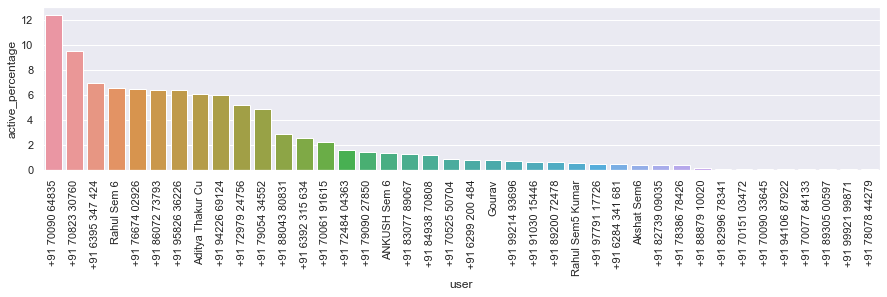

In [ ]:
plt.figure(figsize=(15,3))
sns.barplot(x="user",y="active_percentage",data=user_active_df)
plt.xticks(rotation=90)
plt.show()

# Wordcloud

In [ ]:
df = WCA[WCA["chats"]!='<Media omitted> '].reset_index()
df.drop("index",axis=1,inplace=True)
df.head()

,date,time,username,chats,date_time,Year,Month_name,Month,Day,Hours,Minutes
0,8/2/22,20:58,Gourav,Someone please share the mooc form,2022-08-02 20:58:00,2022,August,8,2,20,58
1,8/2/22,20:59,+91 70090 64835,https://docs.google.com/forms/d/e/1FAIpQLScUyn...,2022-08-02 20:59:00,2022,August,8,2,20,59
2,8/2/22,20:59,Aditya Thakur Cu,Regarding MOOCS-III Pls do not try and uploa...,2022-08-02 20:59:00,2022,August,8,2,20,59
3,8/2/22,20:59,Gourav,Thank 👍,2022-08-02 20:59:00,2022,August,8,2,20,59
4,8/2/22,21:00,Gourav,Thank 👍,2022-08-02 21:00:00,2022,August,8,2,21,0


In [ ]:
# removing stopwords

from nltk.corpus import stopwords

stopword_file = open("stop_hinglish.txt") 
hinglish_stopwords=stopword_file.read()
english_stopwords = stopwords.words('english')

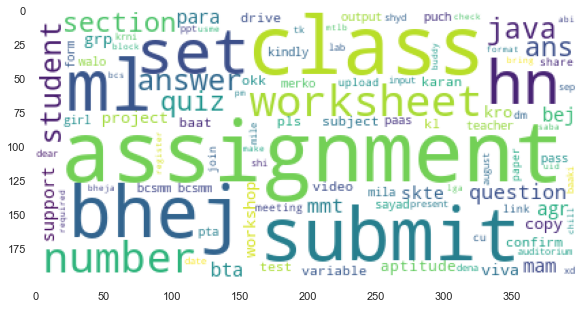

In [ ]:
# overall
from collections import Counter

words=[]


for i in range(df.shape[0]):    
        test_str = df["chats"][i]
        trans_table = test_str.maketrans('','',"""0123456789!"#$%&'()*+,-_–./·:;<=>?@[\]^_`{|}~""")
        test_str = test_str.translate(trans_table)

        for wrd in test_str.lower().split(" "):
            if wrd not in hinglish_stopwords and  wrd not in english_stopwords:
                words.append(wrd)
        
        df["chats"][i]=' '.join(words)
        words=[]
        




plt.figure(figsize=(12,5))
from wordcloud import WordCloud
wc = WordCloud(min_font_size=5,background_color='white')
img_wc=wc.generate(df["chats"].str.cat(sep=" "))
plt.grid(visible=False)
plt.imshow(img_wc)


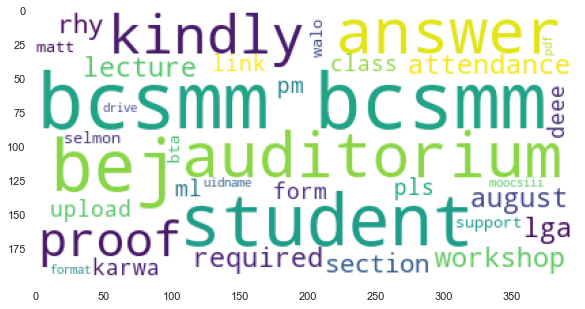

In [ ]:
# for particular user
particular_user = df[df["username"]=='Aditya Thakur Cu'].reset_index()
particular_user.drop("index",axis=1,inplace=True)
particular_user.head()

from collections import Counter

words=[]


for i in range(df.shape[0]):    
#     print(df["chats"][i])
        test_str = df["chats"][i]
        trans_table = test_str.maketrans('','',"""0123456789!"#$%&'()*+,-_–./·:;<=>?@[\]^_`{|}~""")
        test_str = test_str.translate(trans_table)

        for wrd in test_str.lower().split(" "):
            if wrd not in hinglish_stopwords and  wrd not in english_stopwords:
                words.append(wrd)
        
        df["chats"][i]=' '.join(words)
        words=[]

plt.figure(figsize=(12,5))
from wordcloud import WordCloud
wc = WordCloud(min_font_size=5,background_color='white')
img_wc=wc.generate(particular_user["chats"].str.cat(sep=" "))
plt.grid(visible=False)
plt.imshow(img_wc)

# top 25 words

In [ ]:
# removing stopwords

from nltk.corpus import stopwords

stopword_file = open("stop_hinglish.txt") 
hinglish_stopwords=stopword_file.read()
english_stopwords = stopwords.words('english')
  

In [ ]:
from collections import Counter
import emoji

words=[]

emojis=[]

e=[]

for i,j in emoji.get_emoji_unicode_dict('en').items():
    e.append(j)


for msg in WCA["chats"]:
    
    if '<Media omitted>'  not in msg:
        
        test_str = msg
        trans_table = test_str.maketrans('','',"""0123456789!"#$%&'()*+,-_–./·:;<=>?@[\]^_`{|}~""")
        test_str = test_str.translate(trans_table)

        for wrd in test_str.lower().split(" "):
            
            for w in wrd:
                if w not in e:
                    if wrd not in hinglish_stopwords and  wrd not in english_stopwords:
                        words.append(wrd)
                        break
        
      

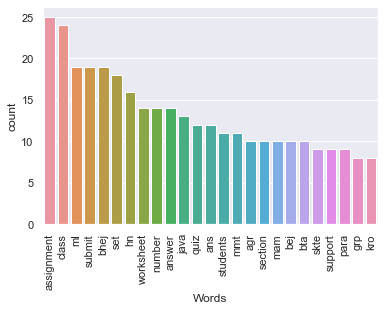

In [ ]:
top_25_words=pd.DataFrame(Counter(words).most_common(25))
# top_25_words
sns.barplot(x=top_25_words[0],y=top_25_words[1])
plt.xticks(rotation=90)
plt.xlabel("Words")
plt.ylabel("count")
plt.show()

# Top emojis

In [ ]:
import emoji

In [ ]:
emojis=[]

e=[]

for i,j in emoji.get_emoji_unicode_dict('en').items():
    e.append(j)


for msg in WCA["chats"]:
    for wrd in msg:
        if wrd in e:
            emojis.append(wrd)


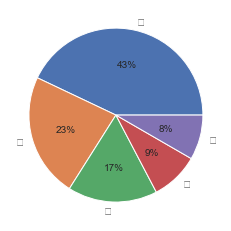

In [ ]:
emoji_count=pd.DataFrame(Counter(emojis).most_common())
plt.pie(emoji_count[1].head(),labels=emoji_count[0].head(),autopct='%.0f%%')
plt.show()

In [ ]:
# for particular user
emojis=[]

e=[]

for i,j in emoji.get_emoji_unicode_dict('en').items():
    e.append(j)

df=WCA[WCA["username"]=='Aditya Thakur Cu']
    
for msg in df["chats"]:
    for wrd in msg:
        if wrd in e:
            emojis.append(wrd)

            
emoji_count=pd.DataFrame(Counter(emojis).most_common())
emoji_count           

,0,1
0,🔥,23
1,😂,17
2,🚩,9
3,🥲,8
4,🎉,6
5,😎,3
6,🥺,3
7,🐍,2
8,🥳,1
9,👍,1


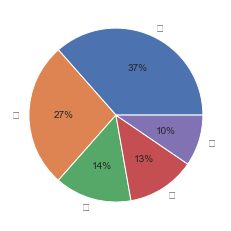

In [ ]:
plt.pie(emoji_count[1].head(),labels=emoji_count[0].head(),autopct='%.0f%%')
plt.show() 

In [ ]:
WCA.head()

,date,time,username,chats,date_time,Year,Month_name,Month,Day,Hours,Minutes
0,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44
1,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44
2,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44
3,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44
4,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44


# Monthly timeline

In [ ]:
monthly_timeline=WCA.groupby(["Year","Month_name"]).count()["chats"].reset_index()
monthly=[]

for i in range(monthly_timeline.shape[0]):
    monthly.append(monthly_timeline["Month_name"][i]+" - "+str(monthly_timeline['Year'][i]))
    
monthly_timeline["monthly_timeline"]=monthly    
          
monthly_timeline.head()

,Year,Month_name,chats,monthly_timeline
0,2022,August,399,August - 2022
1,2022,September,1139,September - 2022


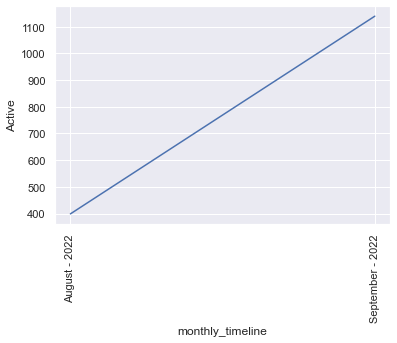

In [ ]:
sns.lineplot(x="monthly_timeline",y="chats",data=monthly_timeline)
plt.ylabel("Active")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# for particular user

df=WCA[WCA["username"]=='Aditya Thakur Cu']

monthly_timeline=df.groupby(["Year","Month_name"]).count()["chats"].reset_index()
monthly=[]

for i in range(monthly_timeline.shape[0]):
    monthly.append(monthly_timeline["Month_name"][i]+" - "+str(monthly_timeline['Year'][i]))
    
monthly_timeline["monthly_timeline"]=monthly    
          
monthly_timeline.head()

,Year,Month_name,chats,monthly_timeline
0,2022,August,24,August - 2022
1,2022,September,70,September - 2022


Text(0, 0.5, 'Active')

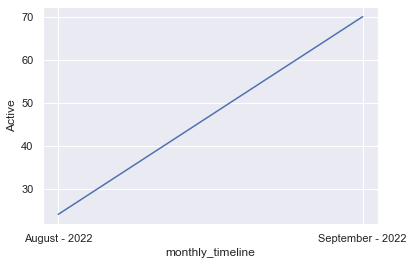

In [ ]:
sns.lineplot(x="monthly_timeline",y="chats",data=monthly_timeline)
plt.ylabel("Active")

# Daily timeline

In [ ]:
daily_timeline=WCA.groupby(["Year","Month_name","Day"]).count()['chats'].reset_index()
daily_timeline.head()

,Year,Month_name,Day,chats
0,2022,August,2,21
1,2022,August,3,21
2,2022,August,6,17
3,2022,August,7,1
4,2022,August,8,36


In [ ]:
daily=[]

for i in range(daily_timeline.shape[0]):
    daily.append(str(daily_timeline["Day"][i])+" - "+daily_timeline["Month_name"][i]+" - "+str(daily_timeline["Year"][i]))
    
daily_timeline["date"] = daily
daily_timeline["date"]=pd.to_datetime(daily_timeline["date"])

daily_timeline.head()

,Year,Month_name,Day,chats,date
0,2022,August,2,21,2022-08-02
1,2022,August,3,21,2022-08-03
2,2022,August,6,17,2022-08-06
3,2022,August,7,1,2022-08-07
4,2022,August,8,36,2022-08-08


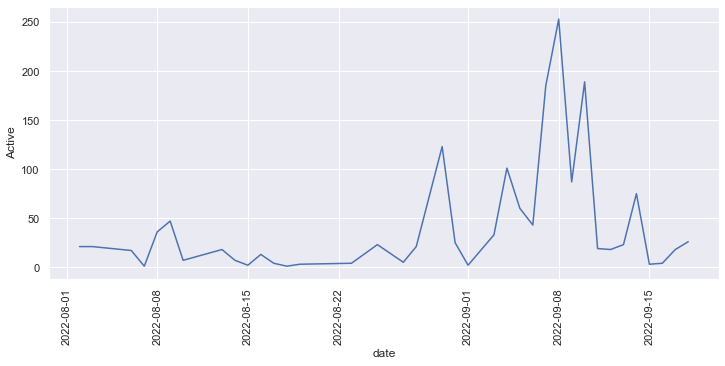

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x="date",y="chats",data=daily_timeline)
plt.ylabel("Active")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# for particular user

df = WCA[WCA["username"]=='Aditya Thakur Cu']
daily_timeline=df.groupby(["Year","Month_name","Day"]).count()['chats'].reset_index()
daily_timeline

,Year,Month_name,Day,chats
0,2022,August,2,1
1,2022,August,3,2
2,2022,August,8,3
3,2022,August,9,7
4,2022,August,23,1
5,2022,August,28,3
6,2022,August,30,7
7,2022,September,4,1
8,2022,September,6,14
9,2022,September,7,20


In [ ]:
daily=[]

for i in range(daily_timeline.shape[0]):
    daily.append(str(daily_timeline["Day"][i])+" - "+daily_timeline["Month_name"][i]+" - "+str(daily_timeline["Year"][i]))
    
daily_timeline["date"] = daily
daily_timeline["date"]=pd.to_datetime(daily_timeline["date"])
daily_timeline

,Year,Month_name,Day,chats,date
0,2022,August,2,1,2022-08-02
1,2022,August,3,2,2022-08-03
2,2022,August,8,3,2022-08-08
3,2022,August,9,7,2022-08-09
4,2022,August,23,1,2022-08-23
5,2022,August,28,3,2022-08-28
6,2022,August,30,7,2022-08-30
7,2022,September,4,1,2022-09-04
8,2022,September,6,14,2022-09-06
9,2022,September,7,20,2022-09-07


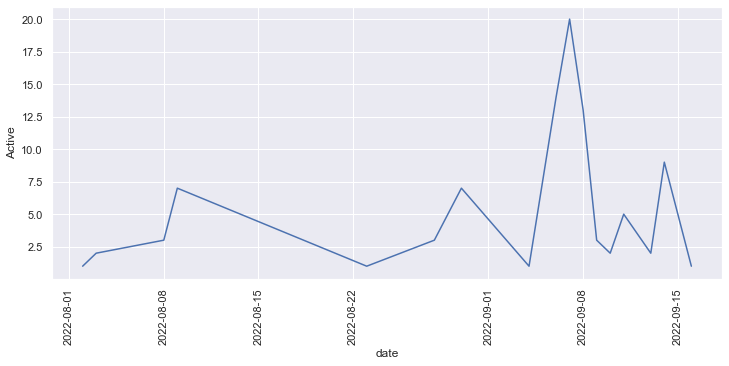

In [ ]:
plt.figure(figsize=(12,5))
sns.lineplot(x="date",y="chats",data=daily_timeline)
plt.ylabel("Active")
plt.xticks(rotation=90)
plt.show()

In [ ]:
f = open("colors_name.txt",'r')

clrs=[]

for i in f:
    if i[0]=='(':
        i = i.replace('(','')
        i = i.replace(')','')
        i = i.replace('\n','')
        
        clrs.append(i)


<AxesSubplot: xlabel='only_date'>

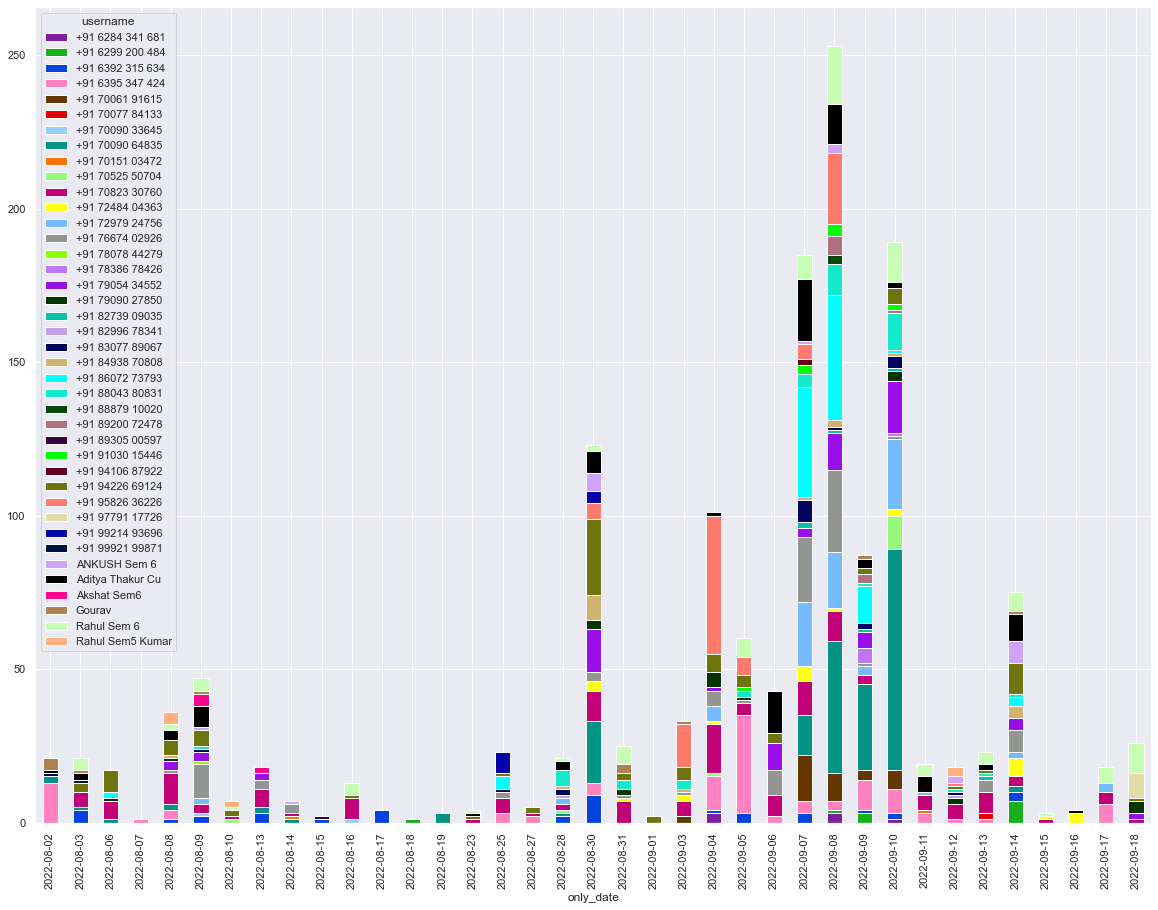

In [ ]:
# for every user

from matplotlib import colors as mcolors
WCA["only_date"]=WCA["date_time"].dt.date

every_user=WCA.pivot_table(index='only_date', columns='username', values='chats', aggfunc='count').fillna(0)
# sns.cubehelix_palette(start=1,rot=1,light=0.75,dark=0.4,n_colors=every_user.shape[1])
every_user.plot(kind='bar',stacked=True,figsize=(20,15),color=clrs)



<AxesSubplot: xlabel='only_date'>

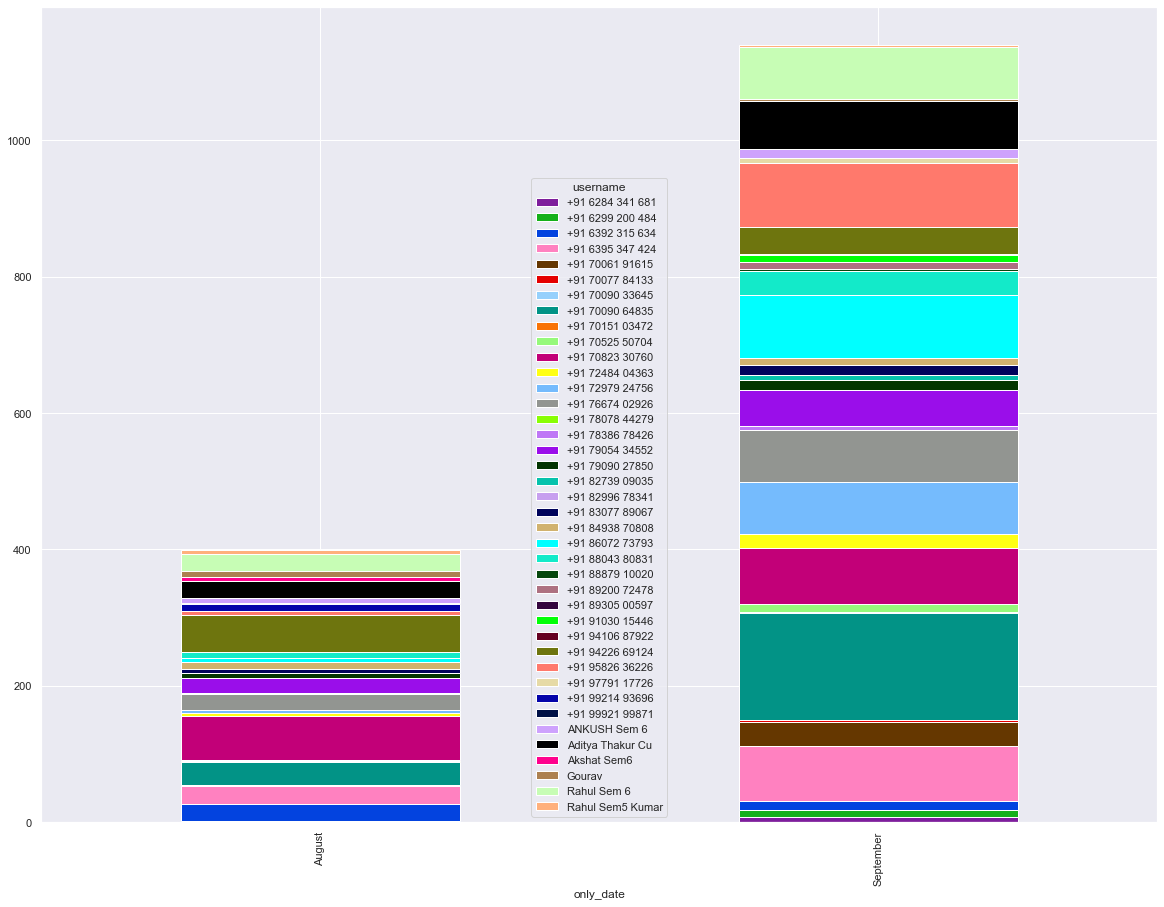

In [ ]:
# for every user month wise


WCA["only_date"]=WCA["date_time"].dt.month_name()

every_user=WCA.pivot_table(index='only_date', columns='username', values='chats', aggfunc='count').fillna(0)
every_user.plot(kind='bar',stacked=True,figsize=(20,15),color=clrs)

<AxesSubplot: xlabel='only_date'>

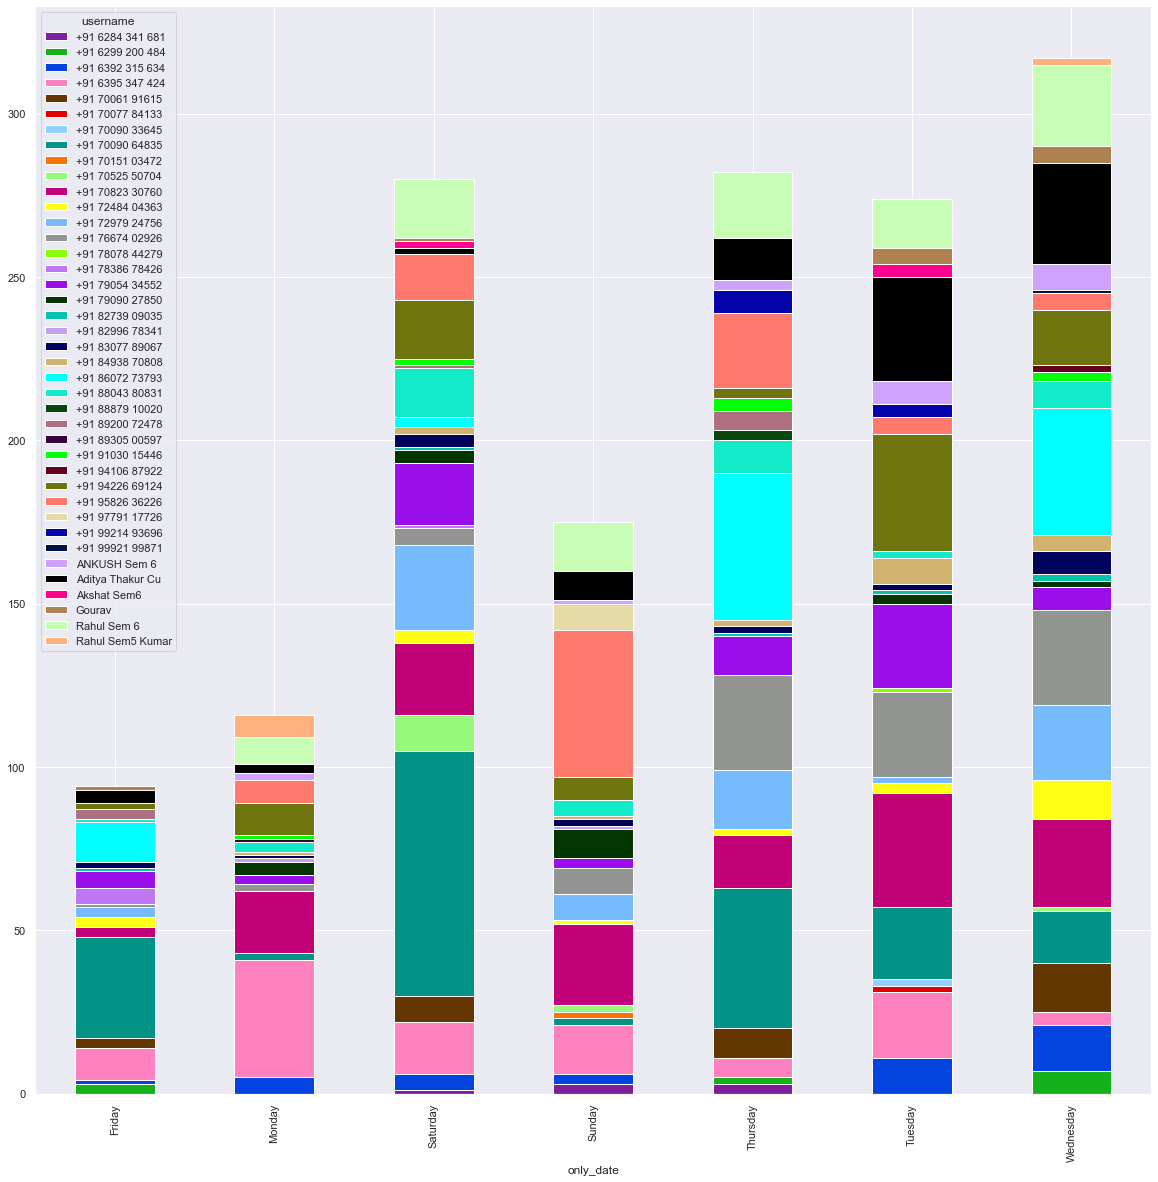

In [ ]:
# for every user month wise


WCA["only_date"]=WCA["date_time"].dt.day_name()

every_user=WCA.pivot_table(index='only_date', columns='username', values='chats', aggfunc='count').fillna(0)
every_user.plot(kind='bar',stacked=True,figsize=(20,20),color=clrs)

# Most busy day

In [ ]:
WCA["Day name"]=WCA["date_time"].dt.day_name()
WCA.head()

,date,time,username,chats,date_time,Year,Month_name,Month,Day,Hours,Minutes,only_date,Day name
0,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday
1,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday
2,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday
3,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday
4,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday


In [ ]:
weekdays=WCA.groupby("Day name").count()["chats"].reset_index()
weekdays

,Day name,chats
0,Friday,94
1,Monday,116
2,Saturday,280
3,Sunday,175
4,Thursday,282
5,Tuesday,274
6,Wednesday,317


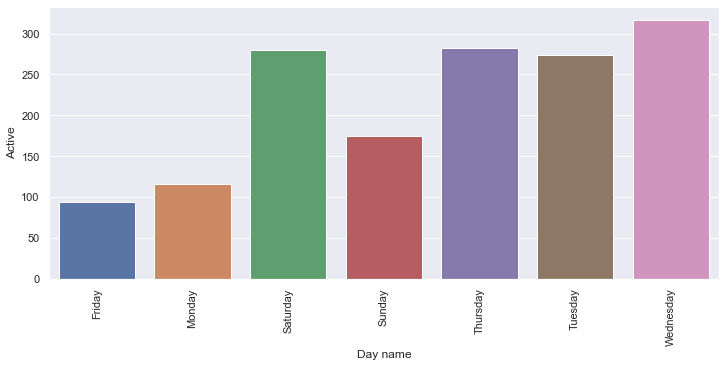

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(x="Day name",y="chats",data=weekdays)
plt.ylabel("Active")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# for particular user
weekdays = WCA[WCA["username"]=='Aditya Thakur Cu']

weekdays=weekdays.groupby("Day name").count()["chats"].reset_index()
weekdays

,Day name,chats
0,Friday,4
1,Monday,3
2,Saturday,2
3,Sunday,9
4,Thursday,13
5,Tuesday,32
6,Wednesday,31


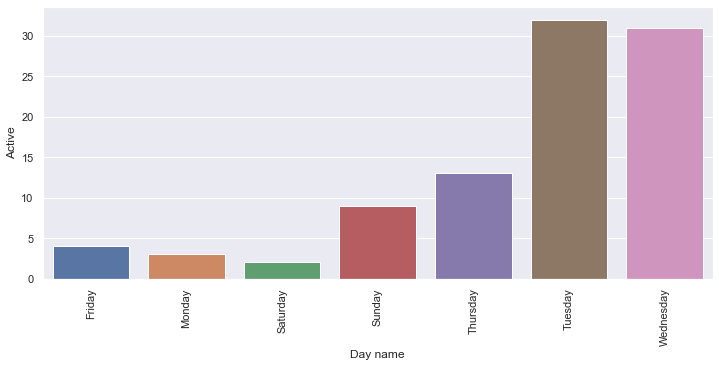

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(x="Day name",y="chats",data=weekdays)
plt.ylabel("Active")
plt.xticks(rotation=90)
plt.show()

# most busy month

In [ ]:
months=WCA.groupby("Month_name").count()["chats"].reset_index()
months

,Month_name,chats
0,August,399
1,September,1139


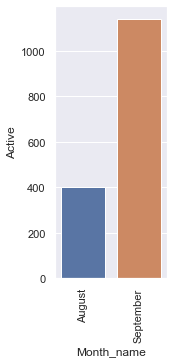

In [ ]:
plt.figure(figsize=(2,5))
sns.barplot(x="Month_name",y="chats",data=months)
plt.ylabel("Active")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# for particular user


months = WCA[WCA["username"]=='Aditya Thakur Cu']

months=months.groupby("Month_name").count()["chats"].reset_index()
months

,Month_name,chats
0,August,24
1,September,70


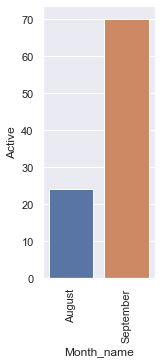

In [ ]:
plt.figure(figsize=(2,5))
sns.barplot(x="Month_name",y="chats",data=months)
plt.ylabel("Active")
plt.xticks(rotation=90)
plt.show()

# Hourly heatmap

In [ ]:
WCA.head()

,date,time,username,chats,date_time,Year,Month_name,Month,Day,Hours,Minutes,only_date,Day name
0,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday
1,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday
2,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday
3,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday
4,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday


In [ ]:
periods=[]

for h in WCA["Hours"]:
    if h==23:
        periods.append(str(h)+"-"+"00")
    elif h==0:
        periods.append("00"+"-"+"01")
    elif h<=8:
        periods.append("0"+str(h)+"-"+"0"+str(h+1))
    else:    
        periods.append(str(h)+"-"+str(h+1))
        
WCA["periods"] = periods
WCA.head()

,date,time,username,chats,date_time,Year,Month_name,Month,Day,Hours,Minutes,only_date,Day name,periods
0,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday,18-19
1,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday,18-19
2,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday,18-19
3,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday,18-19
4,8/2/22,18:44,+91 6395 347 424,<Media omitted>,2022-08-02 18:44:00,2022,August,8,2,18,44,Tuesday,Tuesday,18-19


In [ ]:
hourly = WCA.pivot_table(index='Day name', columns='periods', values='chats', aggfunc='count').fillna(0)
hourly

periods,00-01,01-02,02-03,03-04,06-07,07-08,08-09,10-11,11-12,13-14,...,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-00,9-10
Day name,,,,,,,,,,,,,,,,,,,,,
Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0
Monday,46.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,12.0,3.0,...,0.0,1.0,6.0,0.0,6.0,5.0,25.0,2.0,0.0,0.0
Saturday,1.0,0.0,0.0,0.0,0.0,0.0,1.0,49.0,1.0,138.0,...,0.0,0.0,17.0,2.0,2.0,15.0,4.0,4.0,21.0,7.0
Sunday,15.0,17.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,...,2.0,1.0,8.0,16.0,5.0,16.0,19.0,7.0,53.0,2.0
Thursday,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,121.0,...,5.0,100.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
Tuesday,7.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,17.0,0.0,...,1.0,3.0,23.0,18.0,2.0,21.0,10.0,6.0,45.0,22.0
Wednesday,38.0,0.0,0.0,1.0,3.0,4.0,2.0,1.0,63.0,1.0,...,34.0,16.0,7.0,0.0,2.0,2.0,31.0,7.0,26.0,3.0


<AxesSubplot: xlabel='periods', ylabel='Day name'>

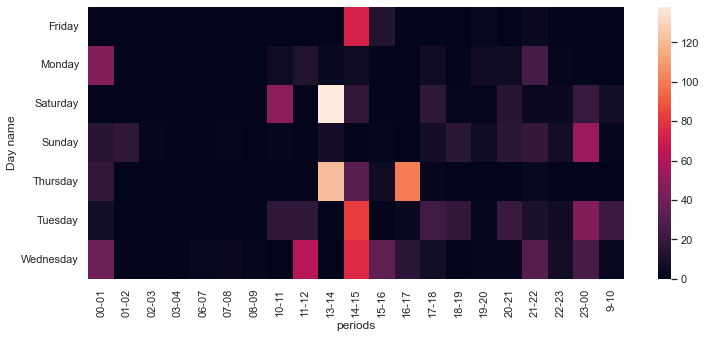

In [ ]:
plt.figure(figsize=(12,5))
sns.heatmap(hourly)

In [ ]:
# for particular user
df = WCA[WCA["username"]=='Aditya Thakur Cu']
hourly = df.pivot_table(index='Day name', columns='periods', values='chats', aggfunc='count').fillna(0)
hourly

periods,00-01,10-11,11-12,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-00,9-10
Day name,,,,,,,,,,,,,,,
Friday,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Monday,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Saturday,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sunday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0
Thursday,0.0,0.0,0.0,4.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tuesday,1.0,3.0,2.0,0.0,7.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,14.0,2.0
Wednesday,7.0,0.0,11.0,0.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: xlabel='periods', ylabel='Day name'>

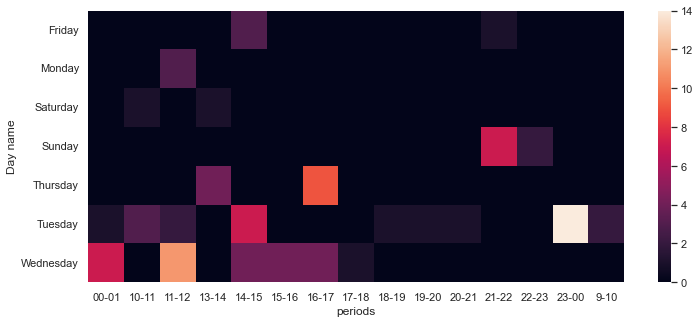

In [ ]:
plt.figure(figsize=(12,5))
sns.heatmap(hourly)

In [ ]:
WCA["only_date"]=WCA["date_time"].dt.date
WCA.tail()

,date,time,username,chats,date_time,Year,Month_name,Month,Day,Hours,Minutes,only_date,Day name,periods
1533,9/18/22,1:31,Rahul Sem 6,https://youtu.be/eo5bmse-Chs,2022-09-18 01:31:00,2022,September,9,18,1,31,2022-09-18,Sunday,01-02
1534,9/18/22,1:42,Rahul Sem 6,https://youtu.be/fqfUwFmEbJU,2022-09-18 01:42:00,2022,September,9,18,1,42,2022-09-18,Sunday,01-02
1535,9/18/22,2:03,+91 79090 27850,"69 signatures are still needed, can you add yo...",2022-09-18 02:03:00,2022,September,9,18,2,3,2022-09-18,Sunday,02-03
1536,9/18/22,7:45,+91 97791 17726,https://twitter.com/MirrorNow/status/157131591...,2022-09-18 07:45:00,2022,September,9,18,7,45,2022-09-18,Sunday,07-08
1537,9/18/22,7:59,+91 97791 17726,https://www.google.com/amp/s/m.jagran.com/lite...,2022-09-18 07:59:00,2022,September,9,18,7,59,2022-09-18,Sunday,07-08


In [ ]:
# import os

# txt_data=[]
# for i in os.listdir("Hinglish data set"):
#     path=f"Hinglish data set\{i}"
#     f = open(path,'r',encoding="mbcs")
#     txt_data.append(f.read())

    
# txt_data=' '.join(txt_data)    
# txt_data

# Similar users

In [ ]:
WCA_copy.drop(["date","time"],inplace=True,axis=1)
WCA_copy

,username,chats
0,+91 6395 347 424,<Media omitted>
1,+91 6395 347 424,<Media omitted>
2,+91 6395 347 424,<Media omitted>
3,+91 6395 347 424,<Media omitted>
4,+91 6395 347 424,<Media omitted>
...,...,...
1533,Rahul Sem 6,https://youtu.be/eo5bmse-Chs
1534,Rahul Sem 6,https://youtu.be/fqfUwFmEbJU
1535,+91 79090 27850,"69 signatures are still needed, can you add yo..."
1536,+91 97791 17726,https://twitter.com/MirrorNow/status/157131591...


In [ ]:
emojis=[]

e=[]

for i,j in emoji.get_emoji_unicode_dict('en').items():
    e.append(j)

e.append('✌')
e.append('✍️')
e.append('☝️')

new_chats=[] 

for msg in WCA_copy["chats"]:
    for words in msg:
        for letters in words:
            if(letters in e):
                msg = msg.replace(letters,"")
    
    new_chats.append(msg)

WCA_copy["chats"]=new_chats 


In [ ]:
from urlextract import URLExtract
extract = URLExtract()

new_chats=[]
for msg in WCA_copy["chats"]:
    for links in extract.find_urls(msg):
        msg=msg.replace(links,'')
    
    new_chats.append(msg)
    
WCA_copy["chats"]=new_chats
WCA_copy=WCA_copy[WCA_copy["chats"]!='<Media omitted> ']

In [ ]:
WCA_copy.drop("index",axis=1,inplace=True)

In [ ]:
WCA_copy=WCA_copy[WCA_copy["chats"]!=' ']

In [ ]:
WCA_copy.reset_index(inplace=True)

In [ ]:
WCA_copy.drop("index",axis=1,inplace=True)

In [ ]:
WCA_copy

,username,chats
0,Gourav,Someone please share the mooc form
1,Aditya Thakur Cu,Regarding MOOCS-III Pls do not try and uploa...
2,Gourav,Thank
3,Gourav,Thank
4,+91 70090 64835,Chill buddy
...,...,...
1007,+91 94226 69124,Full support
1008,+91 79090 27850,"Hello guys, A girl attempted suicide in Cu tod..."
1009,+91 79090 27850,++infinity
1010,+91 70823 30760,Full support


In [ ]:
WCA_copy=WCA_copy.drop_duplicates(keep="first").reset_index().drop("index",axis=1)
WCA_copy 

,username,chats
0,Gourav,Someone please share the mooc form
1,Aditya Thakur Cu,Regarding MOOCS-III Pls do not try and uploa...
2,Gourav,Thank
3,+91 70090 64835,Chill buddy
4,Aditya Thakur Cu,@919422669124
...,...,...
930,+91 94226 69124,Full support
931,+91 79090 27850,"Hello guys, A girl attempted suicide in Cu tod..."
932,+91 79090 27850,++infinity
933,+91 70823 30760,Full support


In [ ]:
user_dict={}

for user in WCA_copy["username"].unique().tolist():
    user_WCA = WCA_copy[WCA_copy["username"]==user]
    
    user_chats=[]
    for msg in user_WCA["chats"]:
        user_chats.append(msg)
    
    user_chats=' '.join(user_chats)
    user_dict[user]=user_chats    

In [ ]:
user_dict

{'Gourav': 'Someone please share the mooc form  Thank   Domain?  You deleted this message  White sheet  Anyone good at node js ',
 'Aditya Thakur Cu': 'Regarding MOOCS-III   Pls do not try and upload ur proofs on the Drive.... pls kindly upload the proofs in the pdf format under the name (UID_NAME)  in the form link...    Link of Form (for proof) :   @919422669124  As per instructions received, a workshop is scheduled in the auditorium of Block-C2 on 9th August, 2022  and for that around 500 students are required from CSE-3rd Year.   Note: It is mandatory for students to bring their laptops during the workshop.   Kindly find the details of the TPP sections(BE CSE/IT 2020 Batch) which are required for a workshop on 9th August, 2022 and they are required to report in the auditorium at 10:25 am sharp.   1. 20BCS_MM-804 2. 20BCS_MM-805 3. 20BCS_MM-806 4. 20BCS_MM-807 5. 20BCS_MM-901 6. 20BCS_MM-902 7. 20BCS_MM-903   @DeepShikha Chhabra  Kindly ensure faculty having lectures in the said dur

In [ ]:
user=[]
chats=[]

for k,v in user_dict.items():
    user.append(k)
    chats.append(v)
    
new_WCA=pd.DataFrame({'user':user,'chats':chats})    

In [ ]:
new_WCA

,user,chats
0,Gourav,Someone please share the mooc form Thank Do...
1,Aditya Thakur Cu,Regarding MOOCS-III Pls do not try and uploa...
2,+91 70090 64835,Chill buddy Cr ne bheja Kya mtlb h Impressi...
3,+91 70823 30760,Congrats Nikhil Congrats karan Grp mein hai ...
4,+91 6392 315 634,Karan bhai apna cr Hn hai @919422669124 Pic...
5,Rahul Sem 6,congratulations karan bhai anyone want to joi...
6,+91 94226 69124,Thanx boiz Han bhai hu sahi h ye bna sakte...
7,+91 99921 99871,*FOR CRYPTO TRADERS* *Daily Earn Profite* ...
8,+91 79090 27850,haan Jaan hi lelo hamaari .... Haan Yahi du...
9,+91 86072 73793,Chal kya rha vha Kitne meeting chalri? Kisi ...


In [ ]:
words=[]


for i in range(new_WCA.shape[0]):    
        test_str = new_WCA["chats"][i]
        trans_table = test_str.maketrans('','',"""0123456789!"#$%&'()*+,-_–./·:;<=>?@[\]^_`{|}~""")
        test_str = test_str.translate(trans_table)

        for wrd in test_str.lower().split(" "):
            if wrd not in hinglish_stopwords and  wrd not in english_stopwords:
                words.append(wrd)
        
        new_WCA["chats"][i]=' '.join(words)
        words=[]

In [ ]:
new_WCA=new_WCA[new_WCA["chats"]!='']
new_WCA.reset_index(inplace=True)
new_WCA.drop("index",axis=1,inplace=True)
new_WCA

,user,chats
0,Gourav,share mooc form domain deleted message white s...
1,Aditya Thakur Cu,moocsiii pls upload proofs drive pls kindly up...
2,+91 70090 64835,chill buddy bheja mtlb impressive buddij daa e...
3,+91 70823 30760,congrats nikhil congrats karan grp voh ptaa im...
4,+91 6392 315 634,karan hn piche baitha workshops block row hn d...
5,Rahul Sem 6,congratulations karan join project group membe...
6,+91 94226 69124,boiz bna meeting join meeting join karlo abi s...
7,+91 99921 99871,crypto traders daily earn profite helping trad...
8,+91 79090 27850,jaan lelo hamaari due list subject ohk ml set ...
9,+91 86072 73793,vha meeting chalri quiz show hora lms soft ski...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_features = 200) 

In [ ]:
WCA_vectors=count_vect.fit_transform(new_WCA["chats"]).toarray()

In [ ]:
WCA_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
WCA_vectors.shape

(36, 200)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
similarity = cosine_similarity(WCA_vectors)

In [ ]:
similarity

array([[1.        , 0.08944272, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08944272, 1.        , 0.06558258, ..., 0.03651484, 0.        ,
        0.        ],
       [0.        , 0.06558258, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.03651484, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
user_index = new_WCA[new_WCA["user"]=="Gourav"].index[0]
user_similar = sorted(list(enumerate(similarity[user_index])),reverse=True,key=lambda x: x[1])

for usr in user_similar[1:4]:
    print(new_WCA.iloc[usr[0]].user," ",usr[1]*100,"%")



+91 99921 99871   35.35533905932737 %
+91 79090 27850   30.151134457776358 %
+91 70525 50704   14.744195615489714 %
